In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from tensorly.base import tensor_to_vec, partial_tensor_to_vec
from tensorly.datasets.synthetic import gen_image
from tensorly.regression.cp_regression import CPRegressor
from tensorly.regression.tucker_regression import TuckerRegressor
from tensorly.decomposition import parafac, tucker
from tensorly.metrics import regression
import tensorly as tl
from imodels.tree.rf_plus.rf_plus import RandomForestPlusRegressor, RandomForestPlusClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, log_loss, accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pprint
from glmnet import ElasticNet, LogitNet
import numpy as np
import pytorch_lightning as pl
import torch
import xgboost as xgb
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
from imodels.tree.rf_plus.data_transformations.block_transformers import MDIPlusDefaultTransformer, IdentityTransformer, CompositeTransformer, TreeTransformer
import tensorly as tl
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
import graphviz
from sklearn import tree
from IPython.display import Image, display
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, RidgeCV , LogisticRegressionCV
import copy,imodels
from tabpfn import TabPFNClassifier
import openml
from tqdm import tqdm
from scipy.spatial import distance
import seaborn as sns
from imodels.tree.rf_plus.rf_plus_prediction_models.aloocv_regression import AloElasticNetRegressorCV, AloLOL2Regressor
from sklearn.metrics.pairwise import *
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, HuberRegressor, LinearRegression   
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from imodels.tree.rf_plus.rf_plus_utils import _fast_r2_score, _neg_log_loss, _get_kernel_shap_rf_plus, _get_lime_scores_rf_plus, _check_X, _check_Xy, _tensorize_data, _tensorize_data_by_tree, _get_sample_split_data
from sklearn.ensemble._forest import _generate_unsampled_indices, _generate_sample_indices
from sklearn import preprocessing
from xgboost import XGBRegressor, XGBClassifier
import l0learn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data 

In [18]:
suite_id = 353#353  # Replace with the desired benchmark suite name
benchmark_suite = openml.study.get_suite(suite_id)
task_ids = benchmark_suite.tasks

In [3]:
task_id = task_ids[4] # Replace with the actual task ID 359935#
task = openml.tasks.get_task(task_id)
dataset_id = task.dataset_id
dataset = openml.datasets.get_dataset(dataset_id)

X, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute,dataset_format="array")

mask_X = np.all(~np.isnan(X), axis=1)
mask_y = ~np.isnan(y)
mask_combined = np.logical_and(mask_X, mask_y)
X = X[mask_combined]
y = y[mask_combined]
#y = y/np.std(y)
#y = np.log(y)



Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_for

In [4]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
pprint.pprint(f"Shape: {X_train_full.shape}")


'Shape: (36584, 9)'


In [5]:
X_train = X_train_full[:1000]
y_train = y_train_full[:1000]
# scaler = preprocessing.StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)#.reshape(-1)
# X_test = scaler.transform(X_test)#.reshape(-1)

# Fit RF and RF+ Model 

In [6]:
rf = RandomForestRegressor(n_estimators=32,min_samples_leaf=2,max_features=0.33,random_state=2)
rf.fit(X_train, y_train)
pprint.pprint(f"RF R2: {r2_score(y_test, rf.predict(X_test))}")


'RF R2: 0.37204855405793136'


In [7]:
xgb = XGBRegressor(n_estimators=40,random_state=1)
xgb.fit(X_train, y_train)
pprint.pprint(f"XGB R2: {r2_score(y_test, xgb.predict(X_test))}")   

'XGB R2: 0.3136351455219235'


In [8]:
ridge_model = RidgeCV(alphas = np.logspace(-5,5,100))
ridge_model.fit(X_train, y_train)
pprint.pprint(f"Ridge R2: {r2_score(y_test, ridge_model.predict(X_test))}")

'Ridge R2: 0.28003237028326555'


In [15]:
import warnings
warnings.filterwarnings('ignore')
rf_plus_reg = RandomForestPlusRegressor(rf_model=rf,fit_on="all",prediction_model=AloElasticNetRegressorCV())
rf_plus_reg.fit(X_train, y_train,n_jobs=-1)
rf_plus_reg.predict(X_test)
pprint.pprint(f"RF R2: {r2_score(y_test, rf_plus_reg.predict(X_test))}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   38.1s finished


'RF R2: 0.38758820996675136'


In [19]:
import warnings
warnings.filterwarnings('ignore')
rf_plus_reg_in_bag = RandomForestPlusRegressor(rf_model=rf,fit_on="inbag",prediction_model=AloElasticNetRegressorCV())
rf_plus_reg_in_bag.fit(X_train, y_train,n_jobs=-1)
rf_plus_reg_in_bag.predict(X_test)
pprint.pprint(f"RF R2: {r2_score(y_test, rf_plus_reg_in_bag.predict(X_test))}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   40.2s finished


'RF R2: 0.36960893857608745'


In [20]:
train_preds = np.zeros((X_train.shape[0],len(rf_plus_reg.transformers_)))
train_oob_preds = np.zeros((X_train.shape[0],len(rf_plus_reg.transformers_)))
train_oob_preds[:,:] = np.nan
train_inbag_preds = np.zeros((X_train.shape[0],len(rf_plus_reg.transformers_)))
train_inbag_preds[:,:] = np.nan


loo_preds = np.zeros((X_train.shape[0],len(rf_plus_reg.transformers_)))
loo_oob_preds = np.zeros((X_train.shape[0],len(rf_plus_reg.transformers_)))
loo_oob_preds[:,:] = np.nan
loo_inbag_preds = np.zeros((X_train.shape[0],len(rf_plus_reg.transformers_)))
loo_inbag_preds[:,:] = np.nan

test_preds = np.zeros((X_test.shape[0],len(rf_plus_reg.transformers_)))


for i in range(len(rf_plus_reg.transformers_)):
    
    
    ith_tree_blocked_data = rf_plus_reg.transformers_[i].transform(X_train)
    ith_tree_train_transformed = ith_tree_blocked_data.get_all_data()
    
    ith_loo_preds = rf_plus_reg.estimators_[i].predict_loo(ith_tree_train_transformed)
    ith_train_preds = rf_plus_reg.estimators_[i].predict(ith_tree_train_transformed)
    
    ith_test_preds = rf_plus_reg.estimators_[i].predict(rf_plus_reg.transformers_[i].transform(copy.deepcopy(X_test)).get_all_data())
    
    oob_indices = _generate_unsampled_indices(rf_plus_reg.rf_model.estimators_[i].random_state, X_train.shape[0], X_train.shape[0])
    inbag_indices = np.unique(_generate_sample_indices(rf_plus_reg.rf_model.estimators_[i].random_state, X_train.shape[0], X_train.shape[0]))
    

    test_preds[:,i] = ith_test_preds
    
    loo_preds[:,i] = ith_loo_preds
    loo_oob_preds[oob_indices,i] = ith_loo_preds[oob_indices]
    loo_inbag_preds[inbag_indices,i] = ith_loo_preds[inbag_indices]

    train_preds[:,i] = ith_train_preds
    train_oob_preds[oob_indices,i] = ith_train_preds[oob_indices]
    train_inbag_preds[inbag_indices,i] = ith_train_preds[inbag_indices]


pprint.pprint(f"Training  R2: {r2_score(y_train, np.mean(train_preds,axis=1))}")
pprint.pprint(f"LOO Training R2: {r2_score(y_train,  np.mean(loo_preds,axis=1))}")

print()

pprint.pprint(f"Training Inbag R2: {r2_score(y_train,  np.nanmean(train_inbag_preds,axis=1))}")
pprint.pprint(f"LOO Inbag Training R2: {r2_score(y_train,  np.nanmean(loo_inbag_preds,axis=1))}")


print()

pprint.pprint(f"Training OOB R2: {r2_score(y_train,  np.nanmean(train_oob_preds,axis=1))}")
pprint.pprint(f"LOO OOB  Training R2: {r2_score(y_train,  np.nanmean(loo_oob_preds,axis=1))}")


print() 

pprint.pprint(f"Test R2: {r2_score(y_test,  np.mean(test_preds,axis=1))}")

'Training  R2: 0.7976456607251742'
'LOO Training R2: 0.7210048558051637'

'Training Inbag R2: 0.8829917359956648'
'LOO Inbag Training R2: 0.8250610842351533'

'Training OOB R2: 0.5777902243241141'
'LOO OOB  Training R2: 0.4601582175153588'

'Test R2: 0.38758820996675136'


In [28]:
loo_preds = np.zeros((X_train.shape[0],len(rf_plus_reg.estimators_)))
for i,est in enumerate(rf_plus_reg.estimators_):
    loo_preds[:,i] = rf_plus_reg.estimators_[i].loo_preds
loo_preds_with_input = np.concatenate([X_train,loo_preds],axis=1)
m = RidgeCV(alphas = np.logspace(-5,5,100),store_cv_values=True) 
m.fit(loo_preds_with_input,y_train)
m.best_score_
#LogisticRegressionCV().fit(loo_preds,y_train)


-6.5967185670327915

In [155]:
rfinbag_inbag_preds = np.zeros((X_train.shape[0],len(rf_plus_reg_in_bag.transformers_)))
rfinbag_inbag_preds[:,:] = np.nan   

rfinbag_oob_preds = np.zeros((X_train.shape[0],len(rf_plus_reg_in_bag.transformers_)))
rfinbag_oob_preds[:,:] = np.nan

rfinbag_inbag_loo_preds = np.zeros((X_train.shape[0],len(rf_plus_reg_in_bag.transformers_)))
rfinbag_inbag_loo_preds[:,:] = np.nan

rfinbag_oob_loo_preds = np.zeros((X_train.shape[0],len(rf_plus_reg_in_bag.transformers_)))
rfinbag_oob_loo_preds[:,:] = np.nan



rfinbag_test_preds = np.zeros((X_test.shape[0],len(rf_plus_reg_in_bag.transformers_)))

rfinbag_oob_preds[:,:] = np.nan
rfinbag_test_preds[:,:] = np.nan

for i in range(len(rf_plus_reg_in_bag.transformers_)):
    ith_rfinbag_tree_blocked_data = rf_plus_reg_in_bag.transformers_[i].transform(X_train)  
    inbag_indices = np.unique(_generate_sample_indices(rf_plus_reg_in_bag.rf_model.estimators_[i].random_state, X_train.shape[0], X_train.shape[0]))
    oob_indices = _generate_unsampled_indices(rf_plus_reg_in_bag.rf_model.estimators_[i].random_state, X_train.shape[0], X_train.shape[0])

    rfinbag_train_preds = rf_plus_reg_in_bag.estimators_[i].predict(ith_rfinbag_tree_blocked_data.get_all_data())
    rfinbag_loo_preds = rf_plus_reg_in_bag.estimators_[i].predict_loo(ith_rfinbag_tree_blocked_data.get_all_data())

    rfinbag_inbag_preds[inbag_indices,i] = rfinbag_train_preds[inbag_indices]
    rfinbag_oob_preds[oob_indices,i] = rfinbag_train_preds[oob_indices]

    rfinbag_inbag_loo_preds[inbag_indices,i] = rfinbag_loo_preds[inbag_indices]
    rfinbag_oob_loo_preds[oob_indices,i] = rfinbag_loo_preds[oob_indices]



    rfinbag_test_preds[:,i] = rf_plus_reg_in_bag.estimators_[i].predict(rf_plus_reg_in_bag.transformers_[i].transform(copy.deepcopy(X_test)).get_all_data())

pprint.pprint(f"Inbag_RF Inbag R2: {r2_score(y_train, np.nanmean(rfinbag_inbag_preds,axis=1))}")
pprint.pprint(f"Inbag_RF Inbag LOO R2: {r2_score(y_train, np.nanmean(rfinbag_inbag_loo_preds,axis=1))}")


pprint.pprint(f"Inbag_RF OOB R2: {r2_score(y_train, np.nanmean(rfinbag_oob_preds,axis=1))}")
pprint.pprint(f"Inbag_RF OOB LOO R2: {r2_score(y_train, np.nanmean(rfinbag_oob_loo_preds,axis=1))}")


pprint.pprint(f"Inbag_RF Test R2: {r2_score(y_test, np.nanmean(rfinbag_test_preds,axis=1))}")


'Inbag_RF Inbag R2: 0.8899389955331053'
'Inbag_RF Inbag LOO R2: 0.855176374070473'
'Inbag_RF OOB R2: 0.35633828978400006'
'Inbag_RF OOB LOO R2: 0.35633828978387616'
'Inbag_RF Test R2: 0.36960893857608745'


# Per Tree Analysis

In [156]:
rfplus_preds = []
rfplus_errors = []

rfplus_inbag_preds = []
rfplus_inbag_errors = []

rf_preds = []
rf_errors = []

ridge_errors = []
ridge_preds = []


for i in range(len(rf_plus_reg.transformers_)):
    ith_tree_test_transformed = rf_plus_reg.transformers_[i].transform(copy.deepcopy(X_test)).get_all_data()
    ith_mean_preds = rf_plus_reg.estimators_[i].predict(ith_tree_test_transformed)
    rfplus_preds.append(ith_mean_preds)
    rfplus_errors.append(np.abs(y_test-ith_mean_preds))

    print(ith_tree_test_transformed.shape)
    ith_inbag_preds = rf_plus_reg_in_bag.estimators_[i].predict(ith_tree_test_transformed)
    rfplus_inbag_preds.append(ith_inbag_preds)
    rfplus_inbag_errors.append(np.abs(y_test-ith_inbag_preds))

    rf_preds.append(rf.estimators_[i].predict(X_test))  
    rf_errors.append(np.abs(y_test-rf.estimators_[i].predict(copy.deepcopy(X_test))))

    ridge_errors.append(np.abs(y_test-ridge_model.predict(X_test)))
    ridge_preds.append(ridge_model.predict(X_test))
    
    pprint.pprint(f"Tree+ {i} R2: {r2_score(y_test,ith_mean_preds)}")
    pprint.pprint(f"Inbag Tree+ {i} R2: {r2_score(y_test,ith_inbag_preds)}")
    pprint.pprint(f"Regular Tree {i} has R2: {r2_score(y_test,rf.estimators_[i].predict(copy.deepcopy(X_test)))}")
    print()

#Takeaway: The RF+ model has a higher R2 score than the regular RF model per tree. However, for some reason, the RF+ model has a lower R2 score than the regular RF model when we average the predictions of all the trees. Why? 

(9146, 273)
'Tree+ 0 R2: 0.1398760615020449'
'Inbag Tree+ 0 R2: 0.04831530784402294'
'Regular Tree 0 has R2: -0.17360546454104675'

(9146, 283)
'Tree+ 1 R2: 0.12329021296506382'
'Inbag Tree+ 1 R2: 0.040123069300596836'
'Regular Tree 1 has R2: -0.11660016386044347'

(9146, 278)
'Tree+ 2 R2: 0.17505429960483354'
'Inbag Tree+ 2 R2: 0.09580594909741036'
'Regular Tree 2 has R2: -0.14006941893658165'

(9146, 287)
'Tree+ 3 R2: 0.07011076912808956'
'Inbag Tree+ 3 R2: 0.047968478264291625'
'Regular Tree 3 has R2: -0.1643661866557833'

(9146, 287)
'Tree+ 4 R2: 0.08651152197593737'
'Inbag Tree+ 4 R2: -0.013173462872383412'
'Regular Tree 4 has R2: -0.18567565817143694'

(9146, 286)
'Tree+ 5 R2: 0.09249931587460802'
'Inbag Tree+ 5 R2: -0.005482955721632932'
'Regular Tree 5 has R2: -0.19995815255030536'

(9146, 286)
'Tree+ 6 R2: 0.09106779313389057'
'Inbag Tree+ 6 R2: 0.08685585980396815'
'Regular Tree 6 has R2: -0.12340991536101042'

(9146, 278)
'Tree+ 7 R2: 0.1264916894583905'
'Inbag Tree+ 7 R2: 0

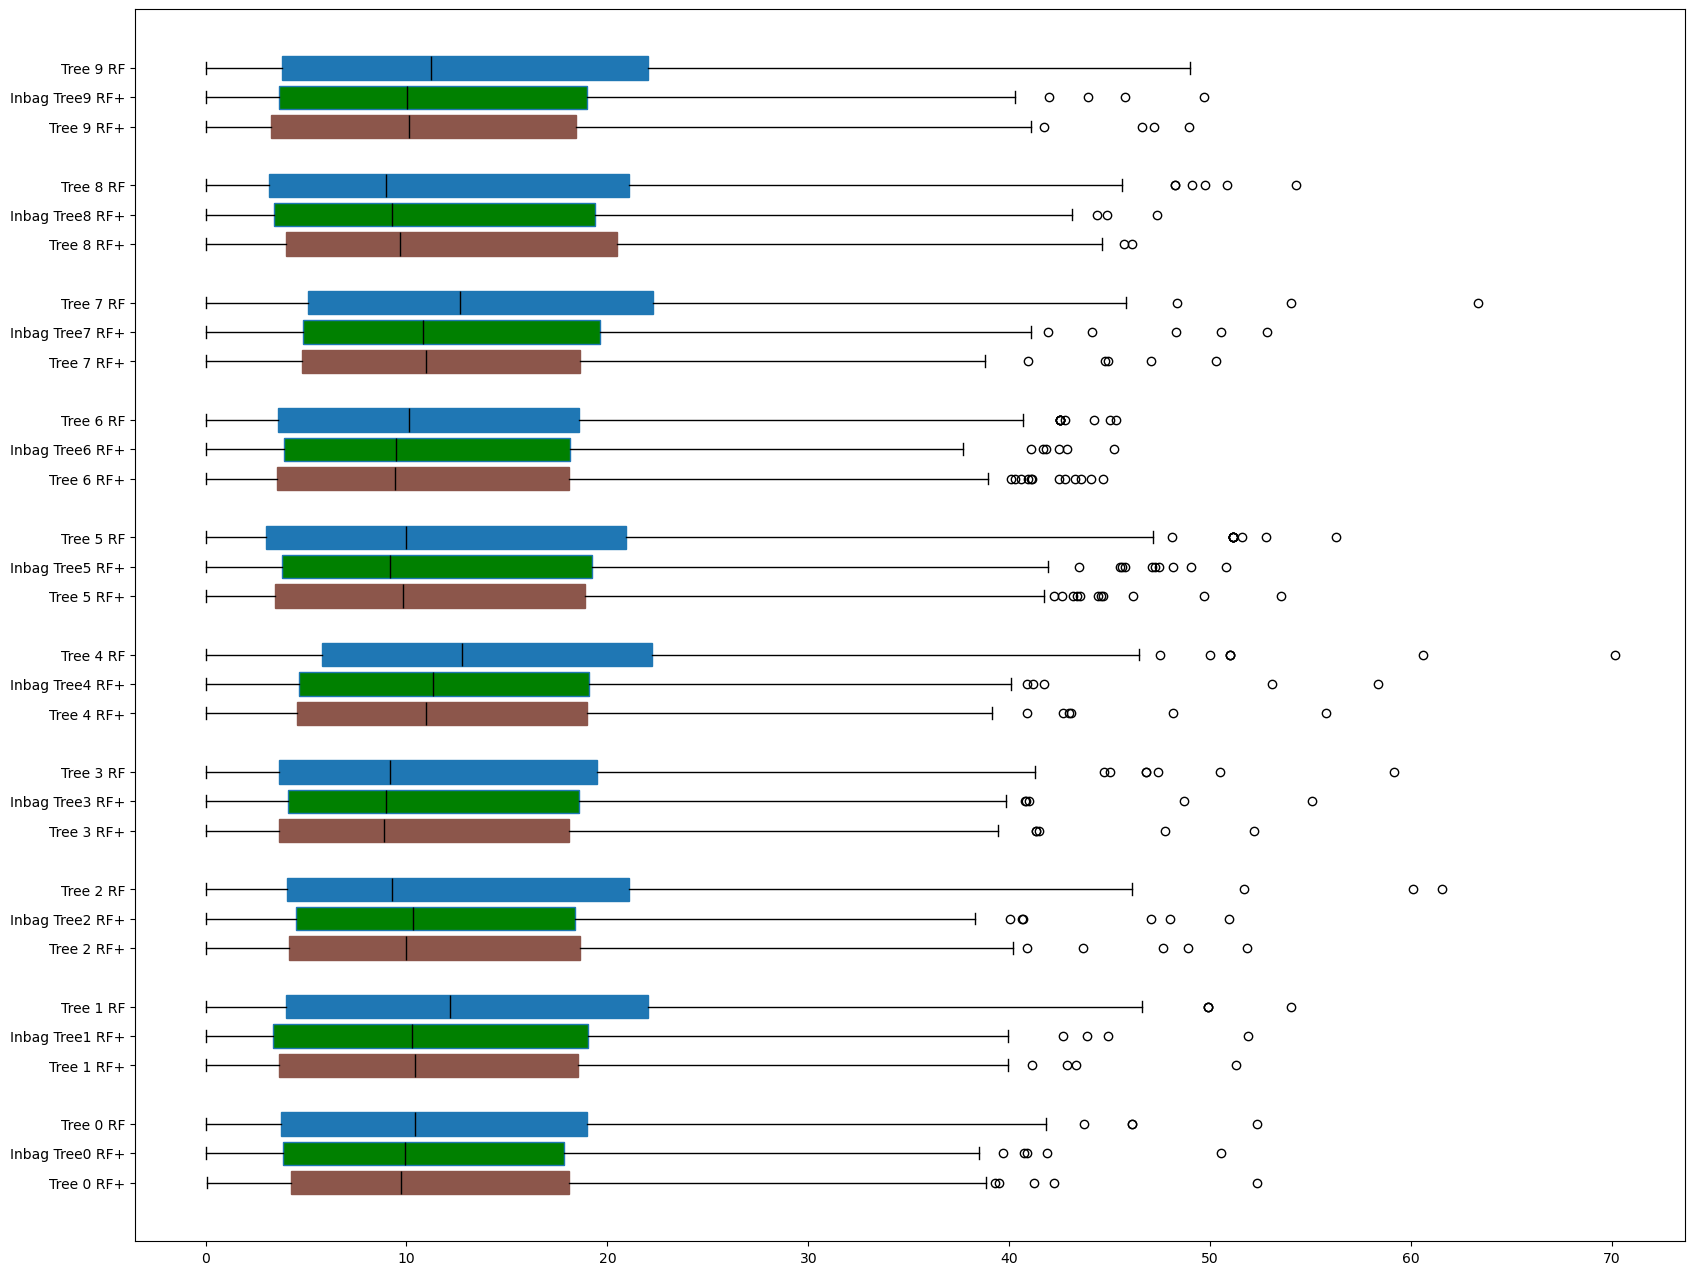

In [116]:
#Boxplot of residuals of RF+ vs RF
fig, ax = plt.subplots(figsize=(20, 16))
num_trees_to_show = min(10,len(rf_plus_reg.transformers_))
box_width = 0.2
sep = 0.05
for i in range(num_trees_to_show):
    ax.boxplot(rfplus_errors[i][:1000], positions=[i], widths=box_width,vert = False, patch_artist=True, boxprops=dict(facecolor='#8c564b', color='#8c564b'),meanprops=dict(color='red'),medianprops=dict(color='black'),labels=[f"Tree {i} RF+"])
    ax.boxplot(rfplus_inbag_errors[i][:1000], positions=[i+box_width + sep], widths=box_width, vert = False, patch_artist=True, boxprops=dict(facecolor='green', color='#1f77b4'),meanprops=dict(color='red'),medianprops=dict(color='black'),labels=[f"Inbag Tree{i} RF+"])
    ax.boxplot(rf_errors[i][:1000], positions=[i+2*box_width + 2*sep], widths=box_width, vert = False, patch_artist=True, boxprops=dict(facecolor='#1f77b4', color='#1f77b4'),meanprops=dict(color='red'),medianprops=dict(color='black'),labels=[f"Tree {i} RF"])
#ax.set_xscale('symlog')

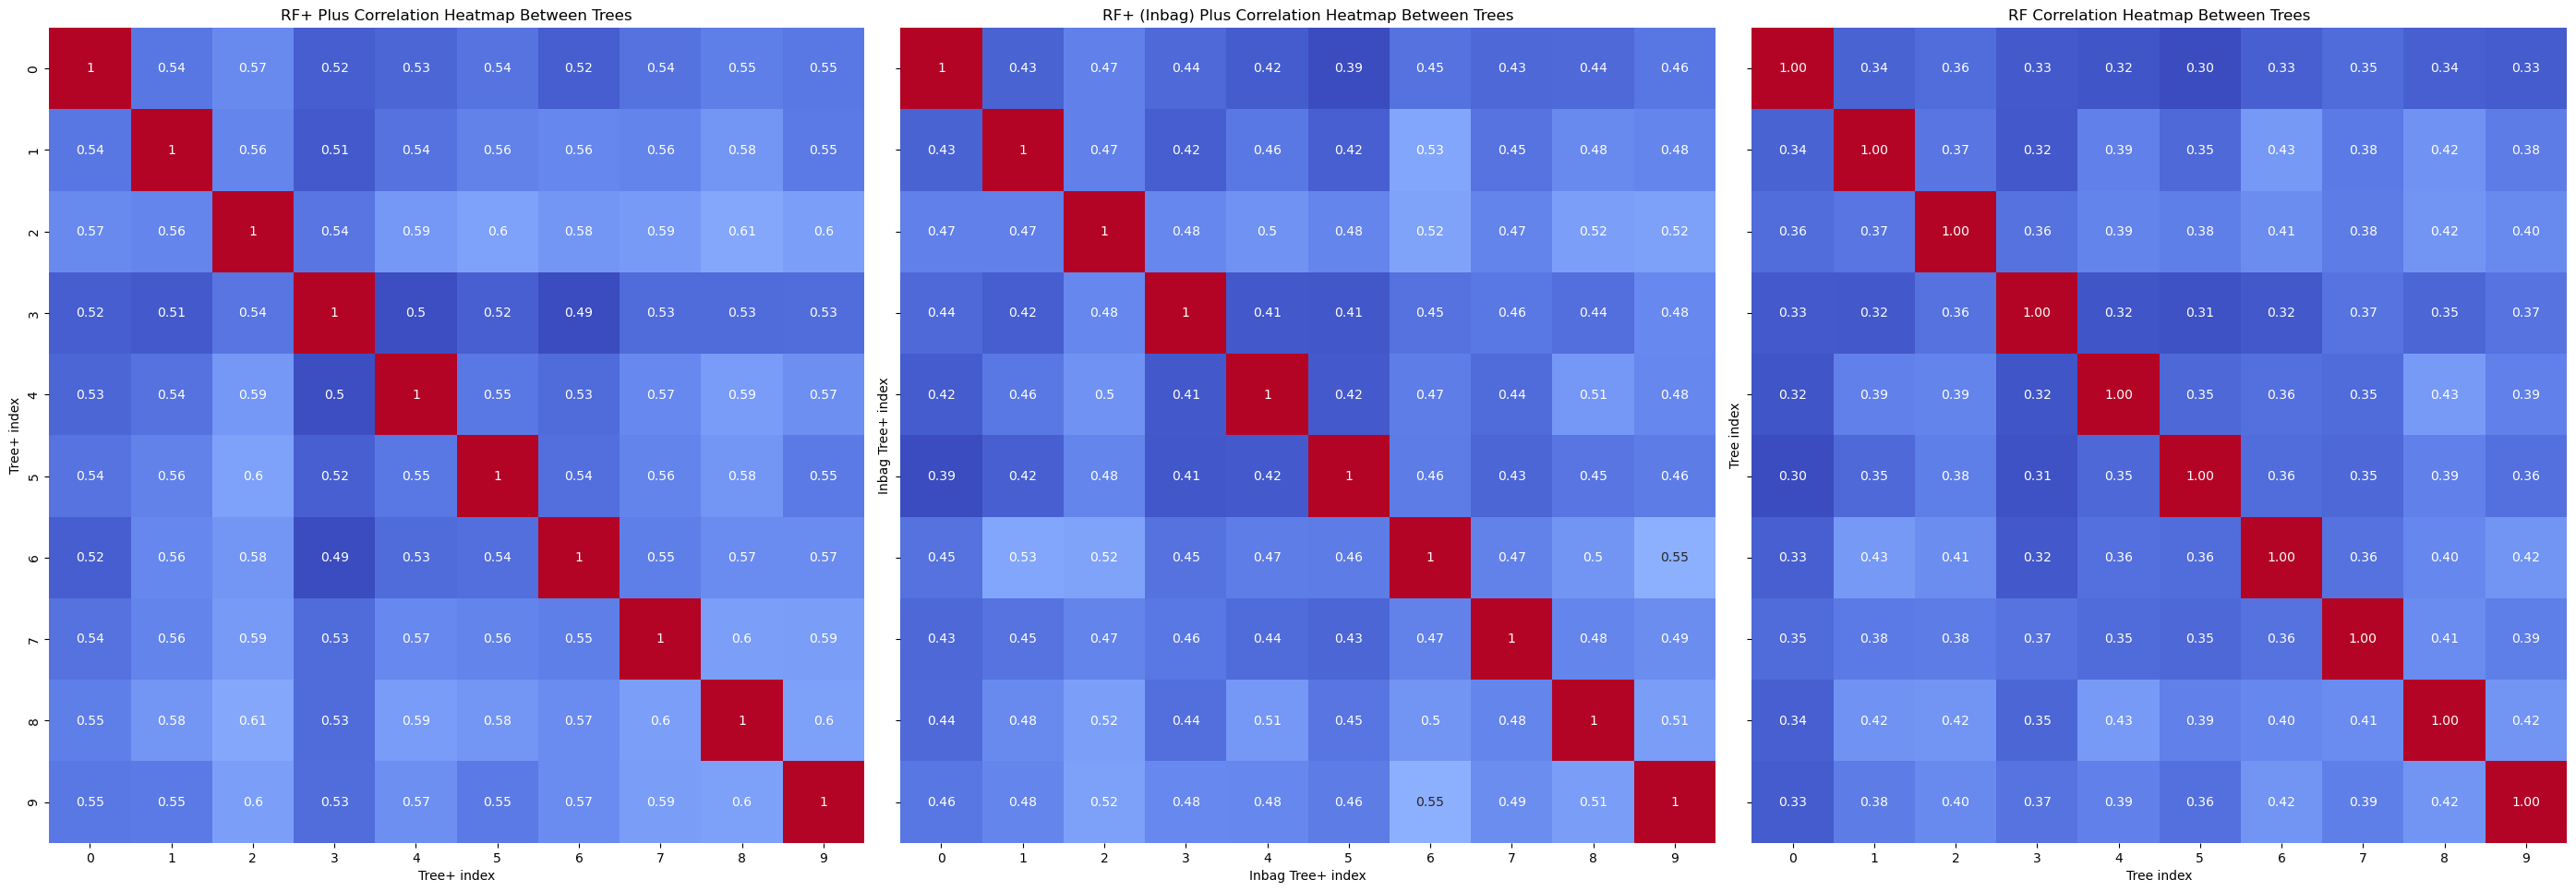

In [157]:
#Correlations between the predictions of the tree+ models
rfplus_preds_matrix = np.column_stack(rfplus_preds)
rfplus_inbag_preds_matrix = np.column_stack(rfplus_inbag_preds)
rf_pred_matrix = np.column_stack(rf_preds)

max_num_trees = 10
# Compute the correlation matrix
rfplus_corr_matrix = np.corrcoef(rfplus_preds_matrix.T[:max_num_trees,:])
rfplus_inbag_corr_matrix = np.corrcoef(rfplus_inbag_preds_matrix.T[:max_num_trees,:])
rf_corr_matrix = np.corrcoef(rf_pred_matrix.T[:max_num_trees,:])


# Create a figure and axis
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (28,22),sharey= True)

# Plot the first correlation heatmap
sns.heatmap(rfplus_corr_matrix, annot=True, cmap='coolwarm', cbar = False, square=True, ax=ax1,annot_kws={'size': 10})
ax1.set_title('RF+ Plus Correlation Heatmap Between Trees')
ax1.set_xlabel('Tree+ index')
ax1.set_ylabel('Tree+ index')

sns.heatmap(rfplus_inbag_corr_matrix, annot=True, cmap='coolwarm', square=True,cbar = False, ax=ax2,annot_kws={'size': 10},)
ax2.set_title('RF+ (Inbag) Plus Correlation Heatmap Between Trees')
ax2.set_xlabel('Inbag Tree+ index')
ax2.set_ylabel('Inbag Tree+ index')


# Plot the second correlation heatmap
sns.heatmap(rf_corr_matrix, annot=True, cmap='coolwarm', square=True, cbar = False,ax=ax3, fmt='.2f', annot_kws={'size': 10})
ax3.set_title('RF Correlation Heatmap Between Trees')
ax3.set_xlabel('Tree index')
ax3.set_ylabel('Tree index')

#cbar = fig.colorbar(ax3.collections[0], ax=[ ax3], use_gridspec=False, pad=0.1,shrink=0.6,orientation='horizontal',location = 'top')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# Per Sample Analysis

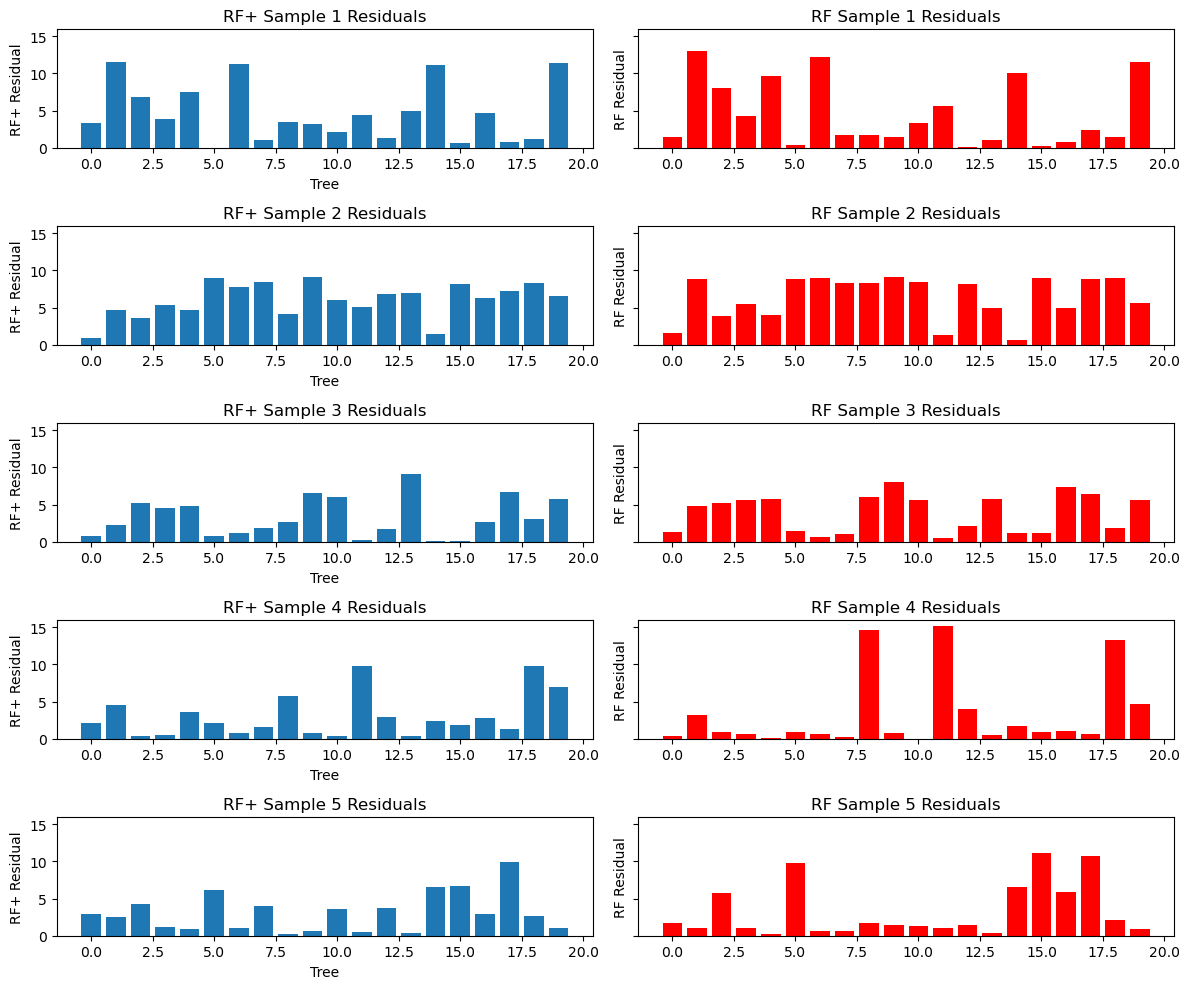

In [159]:
error_matrix = np.column_stack(rfplus_errors)
rf_error_matrix = np.column_stack(rf_errors)
num_rows_to_show = 5
num_cols = error_matrix.shape[1]
fig, axes = plt.subplots(num_rows_to_show, 2, figsize=(12,10),sharey=True)
pred_matrix = np.column_stack(rfplus_preds)
max_trees_to_show = 20
#idx_to_show = np.random.choice(range(len(y_test)),num_rows_to_show)
idx_to_show = list(np.arange(num_rows_to_show))
# Iterate over each row of the matrix
for i,idx in enumerate(idx_to_show):
    # Get the current row data
    row_data = error_matrix[idx][:max_trees_to_show]
    
    rf_row_data = rf_error_matrix[idx][:max_trees_to_show]
    
    # Create a bar plot for the current row
    axes[i][0].bar(range(max_trees_to_show), row_data)
    axes[i][1].bar(range(max_trees_to_show), rf_row_data,color = 'red')
    #axes[i][1].hlines(y_test[idx],0,max_trees_to_show,colors='black',linestyles='dashed')

    # Set the title and labels for the current subplot
    #axes[i].set_title(f"Bar Plot for Row {i+1}")
    axes[i][0].set_xlabel("Tree")
    axes[i][0].set_ylabel("RF+ Residual")
    axes[i][1].set_ylabel("RF Residual")

    axes[i][0].set_title(f"RF+ Sample {idx+1} Residuals")

    axes[i][1].set_title(f"RF Sample {idx+1} Residuals")


        # Adjust the spacing between subplots
    plt.tight_layout()
# Display the plot
plt.show()

(array([1, 2, 3, 4, 5]),
 [Text(0, 1, 'Sample 1'),
  Text(0, 2, 'Sample 2'),
  Text(0, 3, 'Sample 3'),
  Text(0, 4, 'Sample 4'),
  Text(0, 5, 'Sample 5')])

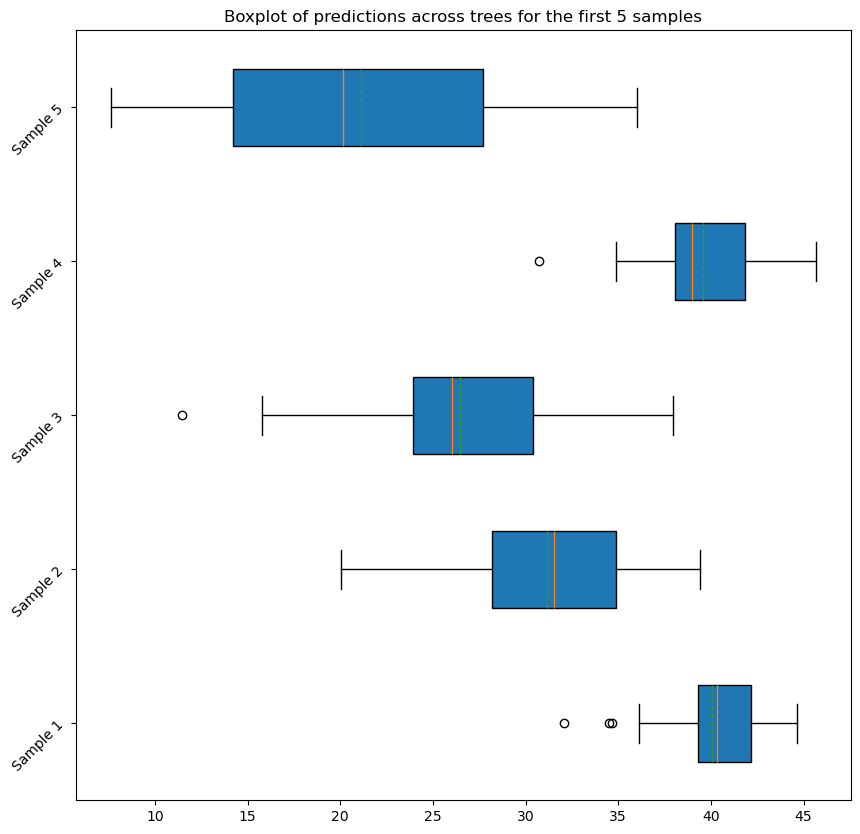

In [120]:
pred_matrix = np.column_stack(rfplus_preds)

fig, ax = plt.subplots(figsize=(10, 10))


# # Create box plots for the first 10 rows
box_plots = ax.boxplot(pred_matrix[:num_rows_to_show].T, vert=False, patch_artist=True,meanline=True,showmeans=True)

# # Set the x-axis tick labels to the row numbers
ax.set_yticks(np.arange(1, num_rows_to_show+1))
ax.set_yticklabels([f"Sample {i+1}" for i in range(num_rows_to_show)])

plt.title(f"Boxplot of predictions across trees for the first {num_rows_to_show} samples")  
# Rotate the y-axis tick labels for better visibility
plt.sca(ax)
plt.yticks(rotation=45)


# LOO error

In [160]:
def sample_indicator_in_tree(rfplus_estimator,X_train):
    sample_indicator_matrix = np.zeros((X_train.shape[0],len(rfplus_estimator.transformers_)))
    sample_indicator_matrix[:,:] = True
    oob_matrix = rfplus_estimator._oob_indices
    for i in range(sample_indicator_matrix.shape[1]):
        sample_indicator_matrix[oob_matrix[i],i] = False
    return sample_indicator_matrix


In [161]:
loo_preds = []
loo_errors = []
train_preds = []
train_errors = []
sample_indicator_matrix = sample_indicator_in_tree(rf_plus_reg,X_train)

for i in tqdm(range(len(rf_plus_reg.transformers_))):
    ith_tree_train_transformed = rf_plus_reg.transformers_[i].transform(X_train).get_all_data()
    loo_preds.append(rf_plus_reg.estimators_[i].predict_loo(ith_tree_train_transformed))

    loo_errors.append(np.abs(y_train-loo_preds[i]))

    train_preds.append(rf_plus_reg.estimators_[i].predict(ith_tree_train_transformed))
    train_errors.append(np.abs(y_train- train_preds[i]))



  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 56.70it/s]


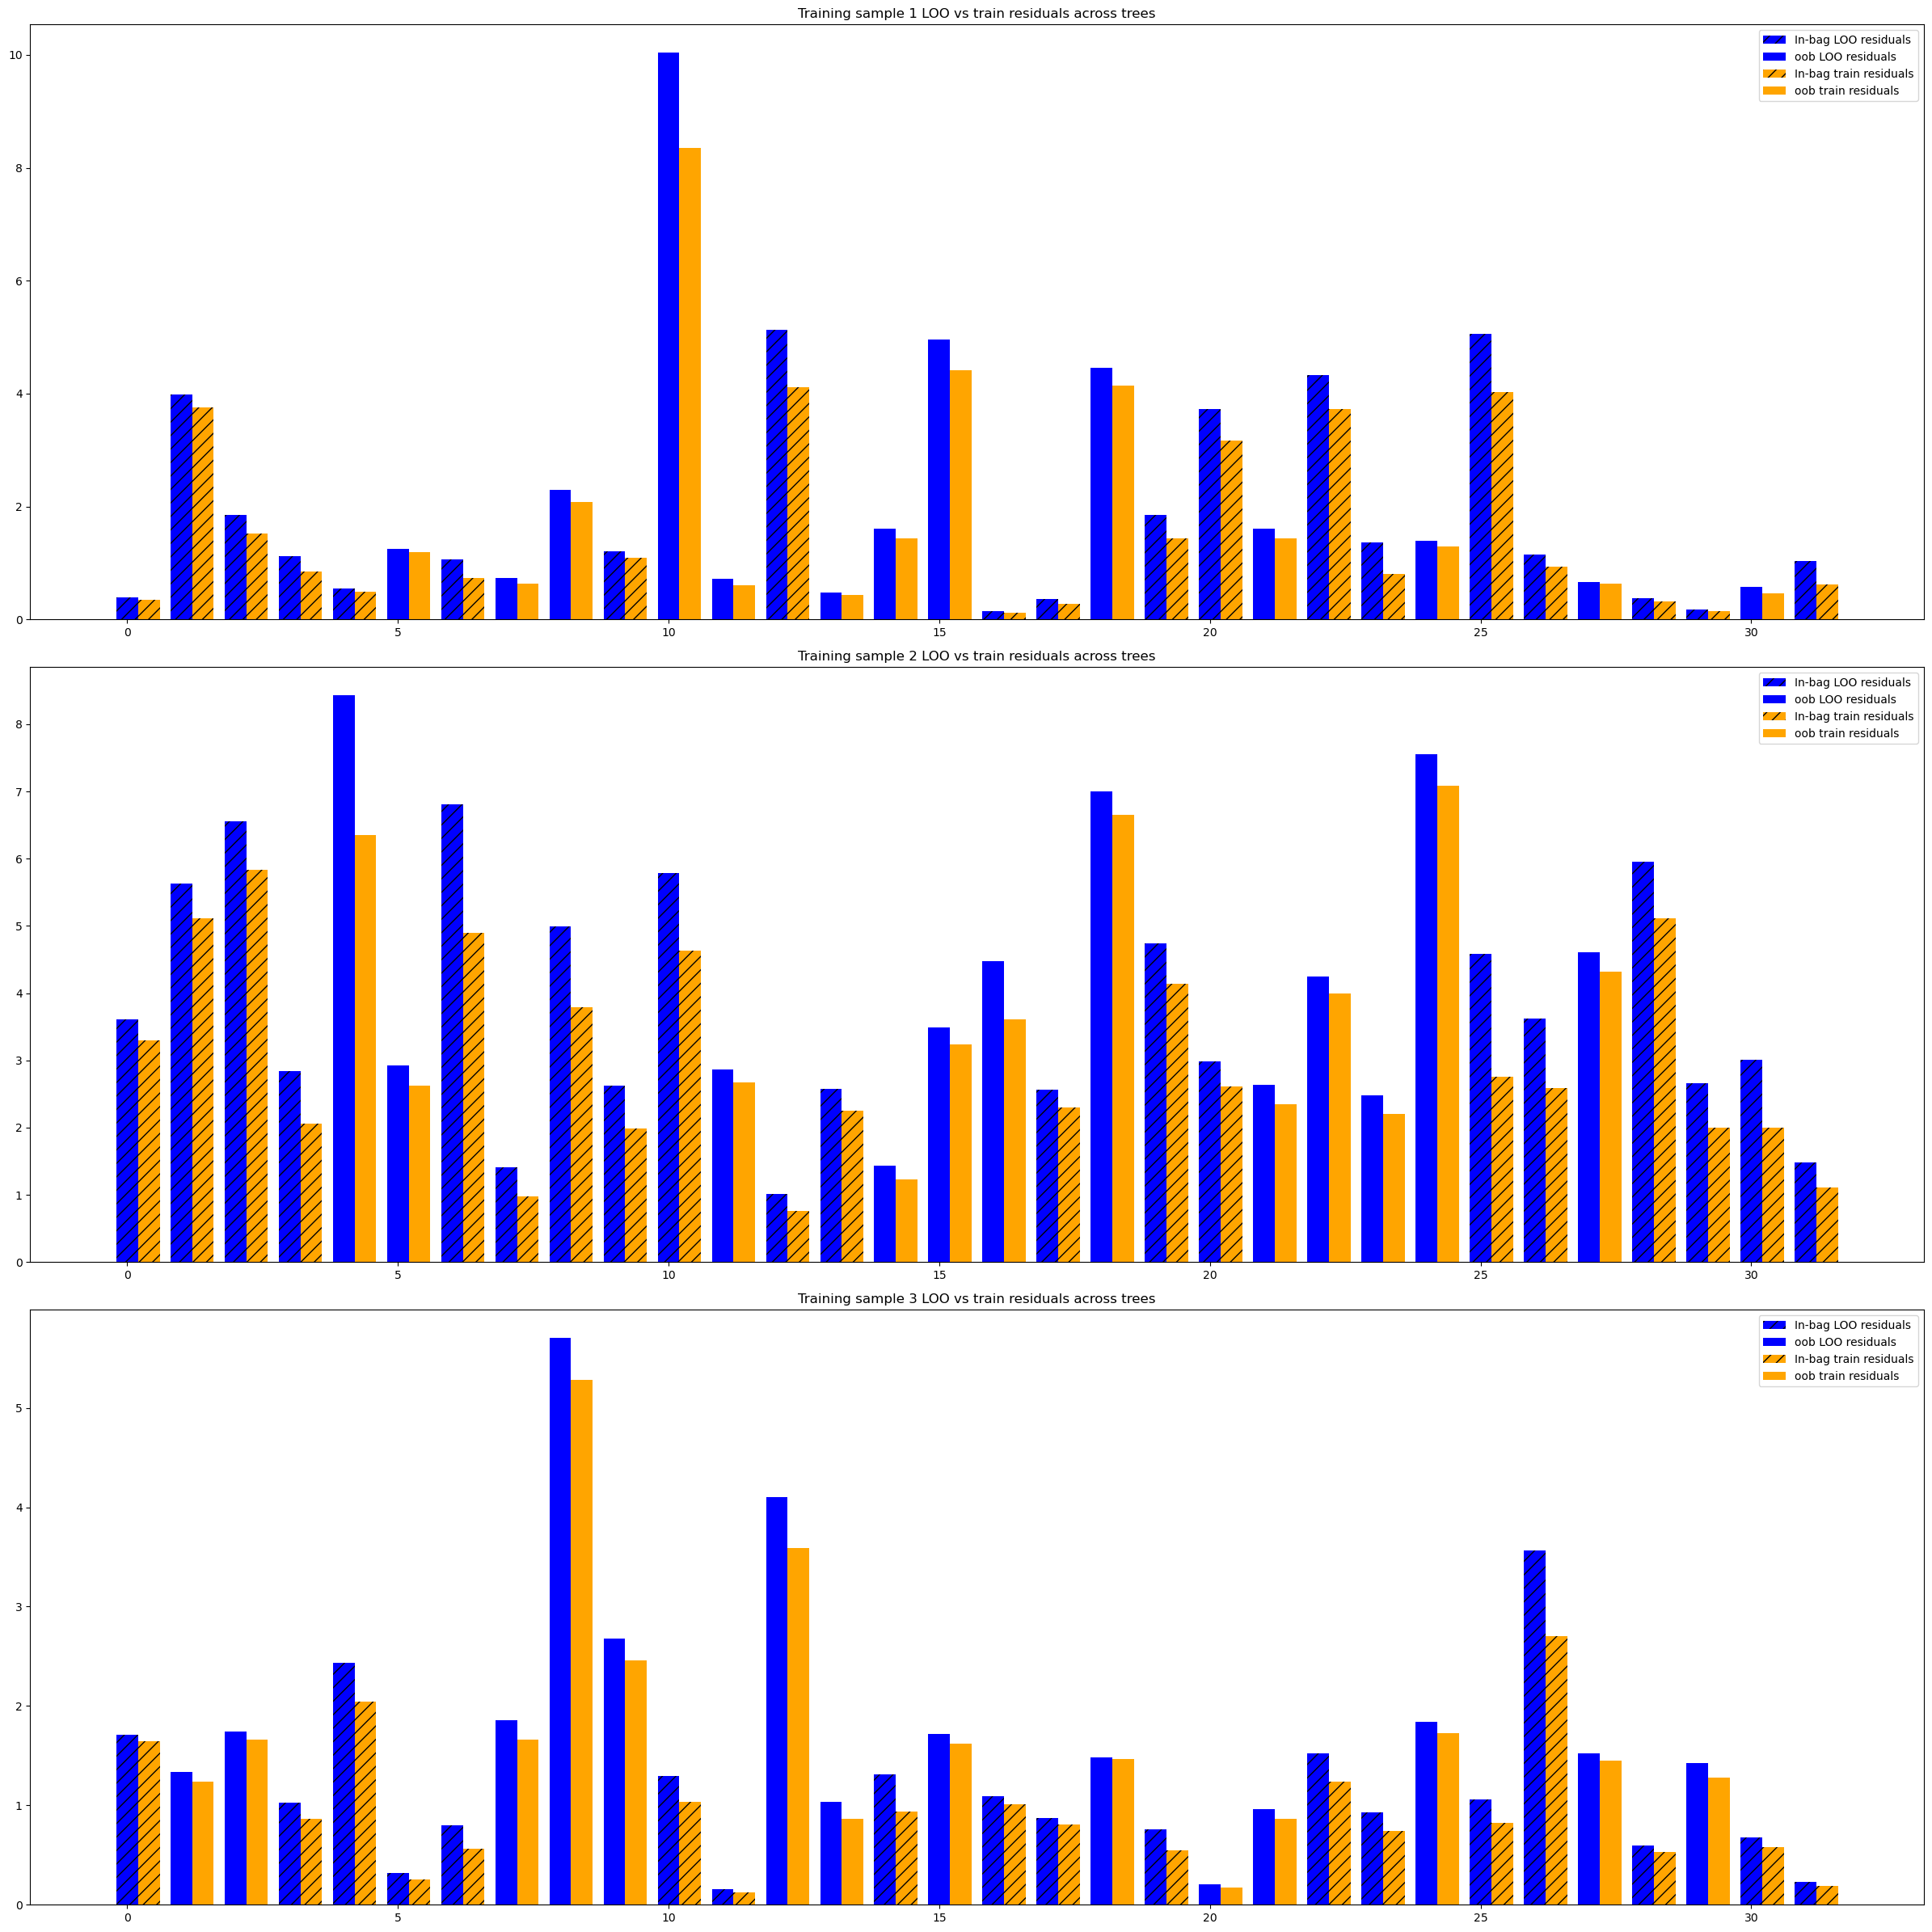

In [162]:
loo_error_matrix = np.column_stack(loo_errors)
train_error_matrix = np.column_stack(train_errors)

num_cols = loo_error_matrix.shape[1]
fig, axes = plt.subplots(min(num_rows_to_show,3), 1, figsize=(24,24),sharey=False)

max_trees_to_show = 20
bar_width = 0.4

# Iterate over each row of the matrix
for i in range(min(num_rows_to_show,3)):
    # Get the current row data
    loo_row_data = loo_error_matrix[i]
    train_row_data = train_error_matrix[i]
    row_in_bag_indicator = sample_indicator_matrix[i]

    in_bag_trees = np.where(row_in_bag_indicator == 1)[0]
    out_of_bag_trees = np.where(row_in_bag_indicator == 0)[0]
    

    positions = range(max_trees_to_show)
    # Create a bar plot for the current row

    
    axes[i].bar(in_bag_trees, loo_row_data[in_bag_trees],width = bar_width,
                  color='blue', label='In-bag LOO residuals',alpha = 1.0,hatch='//')

    axes[i].bar(out_of_bag_trees, loo_row_data[out_of_bag_trees],width = bar_width,
                  color='blue', label='oob LOO residuals',alpha = 1.0)

    xticks_inbag = [x + bar_width for x in in_bag_trees]
    xticks_oob = [x + bar_width for x in out_of_bag_trees]
    
    axes[i].bar(xticks_inbag, train_row_data[in_bag_trees],width = bar_width,
                  color='orange', label='In-bag train residuals',alpha = 1.0,hatch='//')

    axes[i].bar(xticks_oob, train_row_data[out_of_bag_trees],width = bar_width,
                  color='orange', label='oob train residuals',alpha = 1.0)


    axes[i].set_title(f"Training sample {i+1} LOO vs train residuals across trees")
    axes[i].legend()
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    

# Display the plot
plt.show()



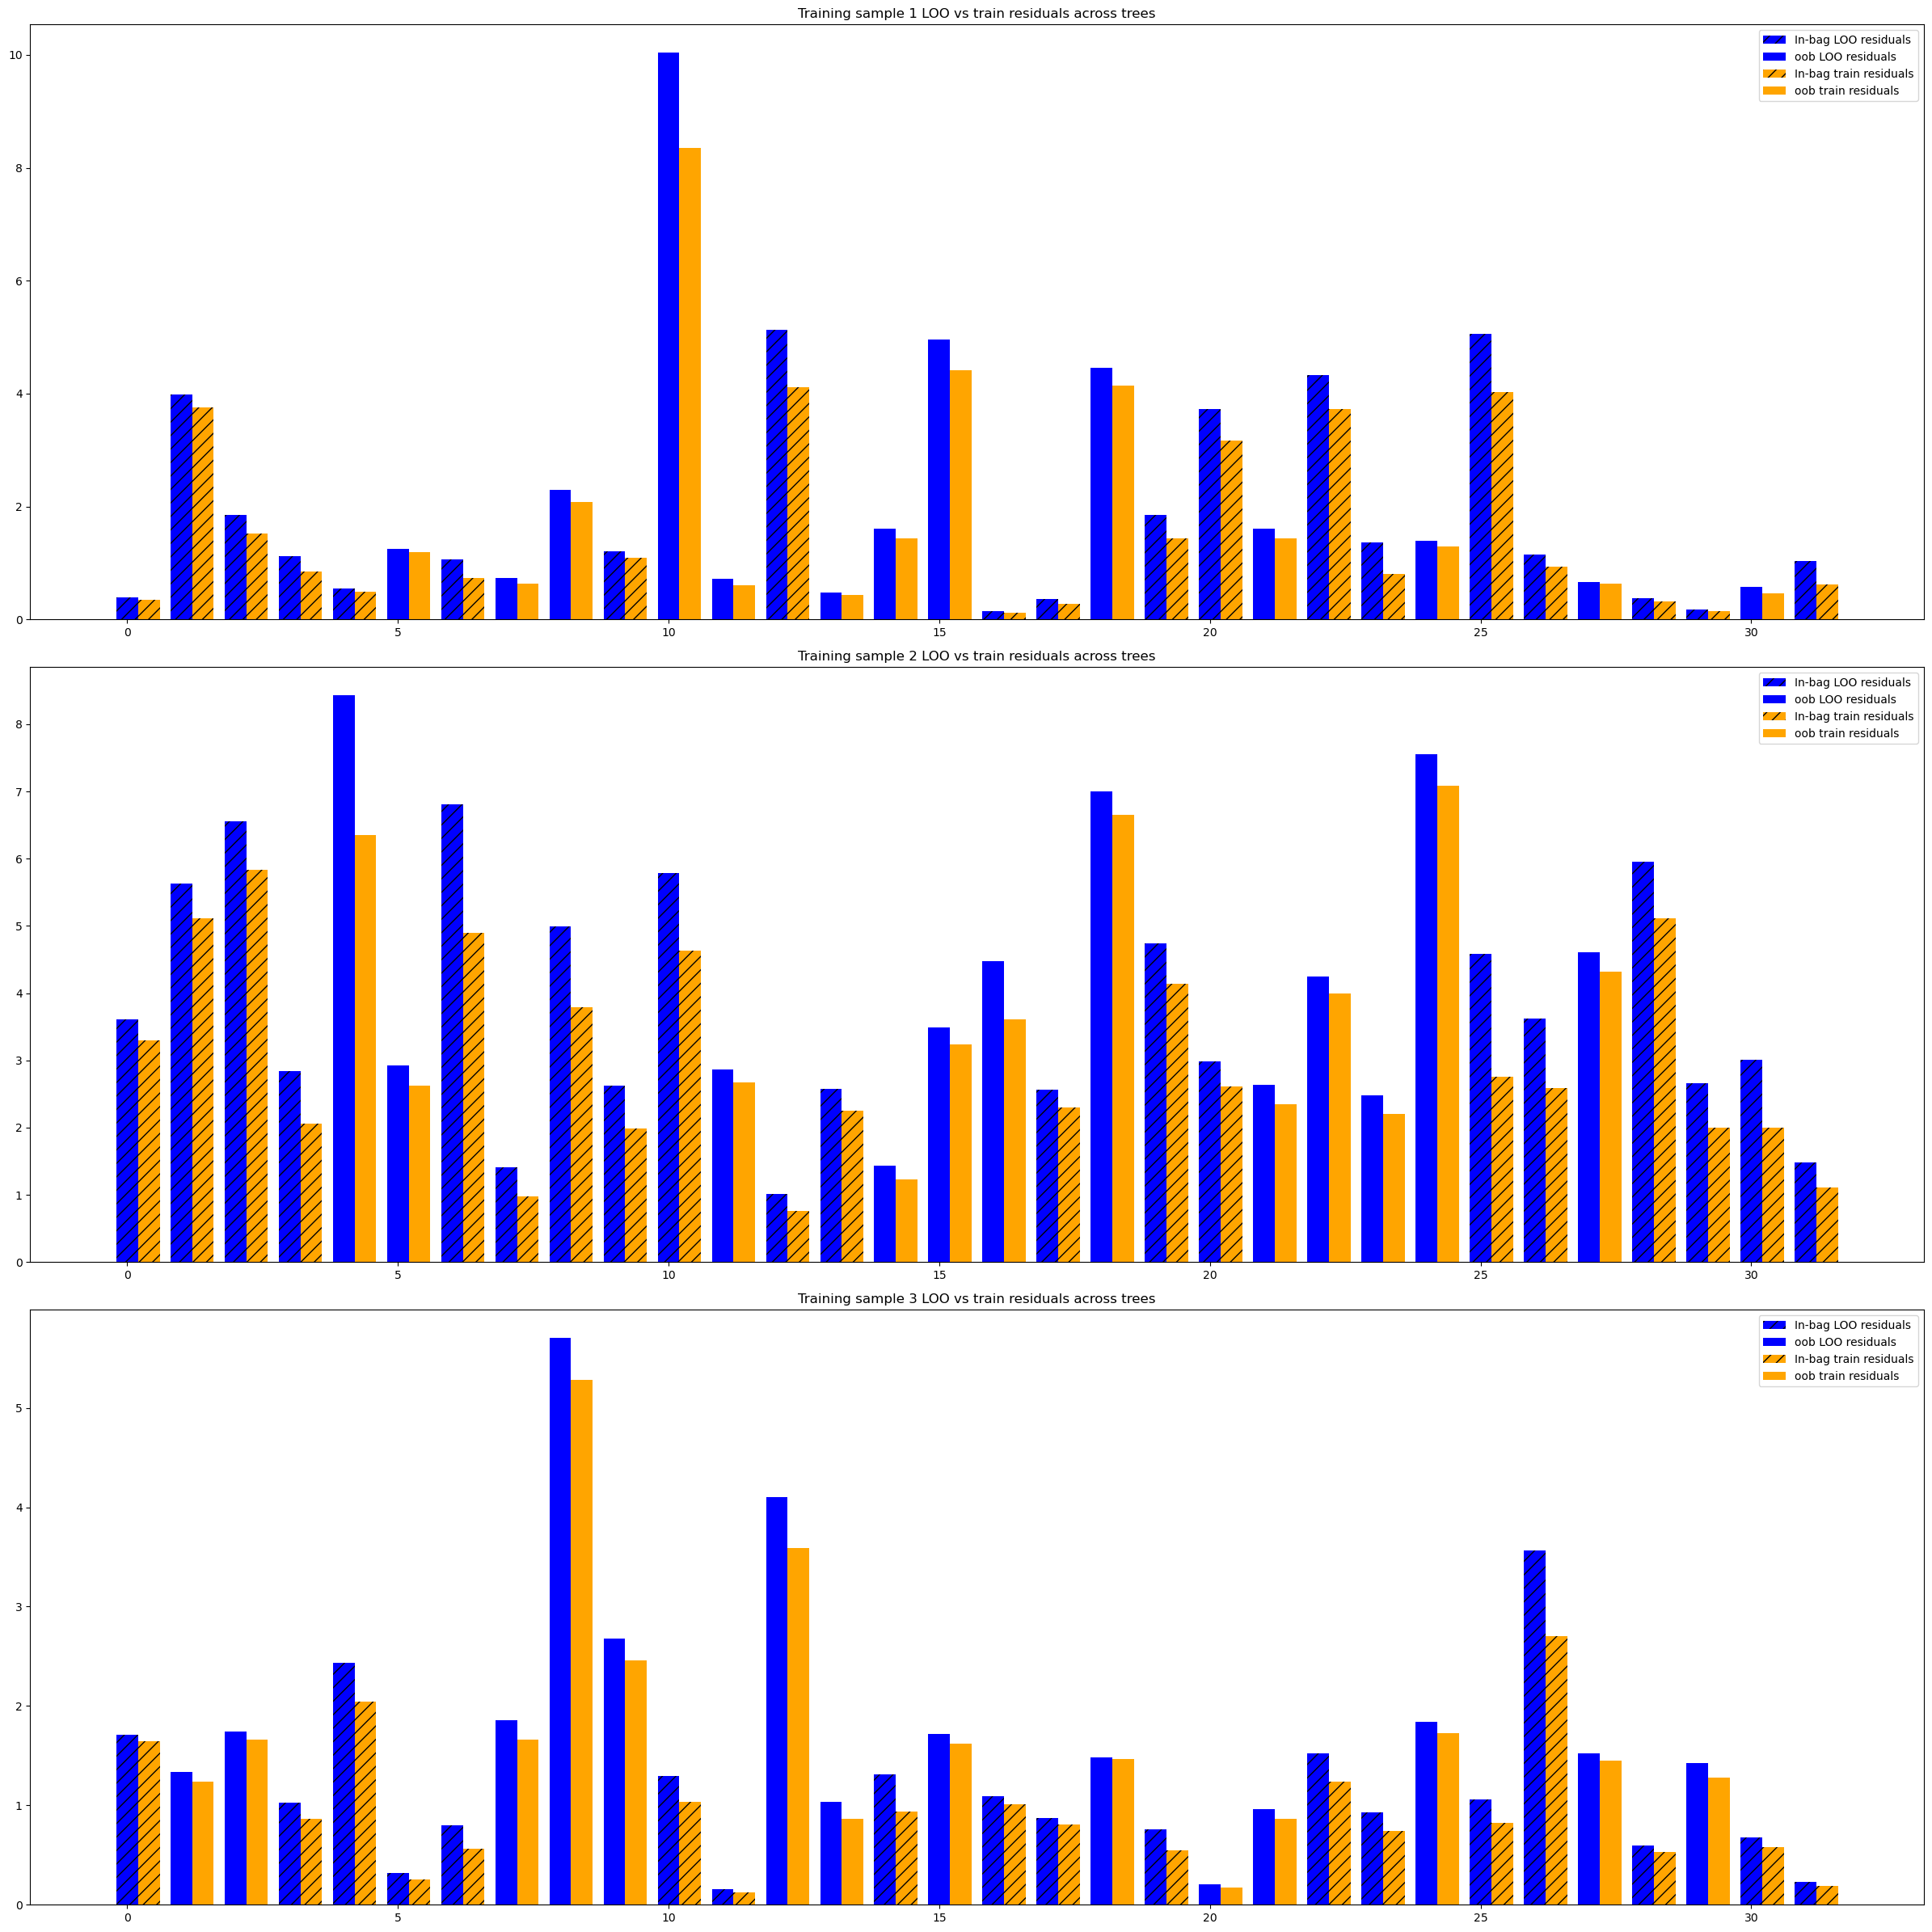

In [163]:
loo_error_matrix = np.column_stack(loo_errors)
train_error_matrix = np.column_stack(train_errors)

num_cols = loo_error_matrix.shape[1]
fig, axes = plt.subplots(min(num_rows_to_show,3), 1, figsize=(24,24),sharey=False)

max_trees_to_show = 20
bar_width = 0.4

# Iterate over each row of the matrix
for i in range(min(num_rows_to_show,3)):
    # Get the current row data
    loo_row_data = loo_error_matrix[i]
    train_row_data = train_error_matrix[i]
    row_in_bag_indicator = sample_indicator_matrix[i]

    in_bag_trees = np.where(row_in_bag_indicator == 1)[0]
    out_of_bag_trees = np.where(row_in_bag_indicator == 0)[0]
    

    positions = range(max_trees_to_show)
    # Create a bar plot for the current row

    
    axes[i].bar(in_bag_trees, loo_row_data[in_bag_trees],width = bar_width,
                  color='blue', label='In-bag LOO residuals',alpha = 1.0,hatch='//')

    axes[i].bar(out_of_bag_trees, loo_row_data[out_of_bag_trees],width = bar_width,
                  color='blue', label='oob LOO residuals',alpha = 1.0)

    xticks_inbag = [x + bar_width for x in in_bag_trees]
    xticks_oob = [x + bar_width for x in out_of_bag_trees]
    
    axes[i].bar(xticks_inbag, train_row_data[in_bag_trees],width = bar_width,
                  color='orange', label='In-bag train residuals',alpha = 1.0,hatch='//')

    axes[i].bar(xticks_oob, train_row_data[out_of_bag_trees],width = bar_width,
                  color='orange', label='oob train residuals',alpha = 1.0)


    axes[i].set_title(f"Training sample {i+1} LOO vs train residuals across trees")
    axes[i].legend()
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    

# Display the plot
plt.show()

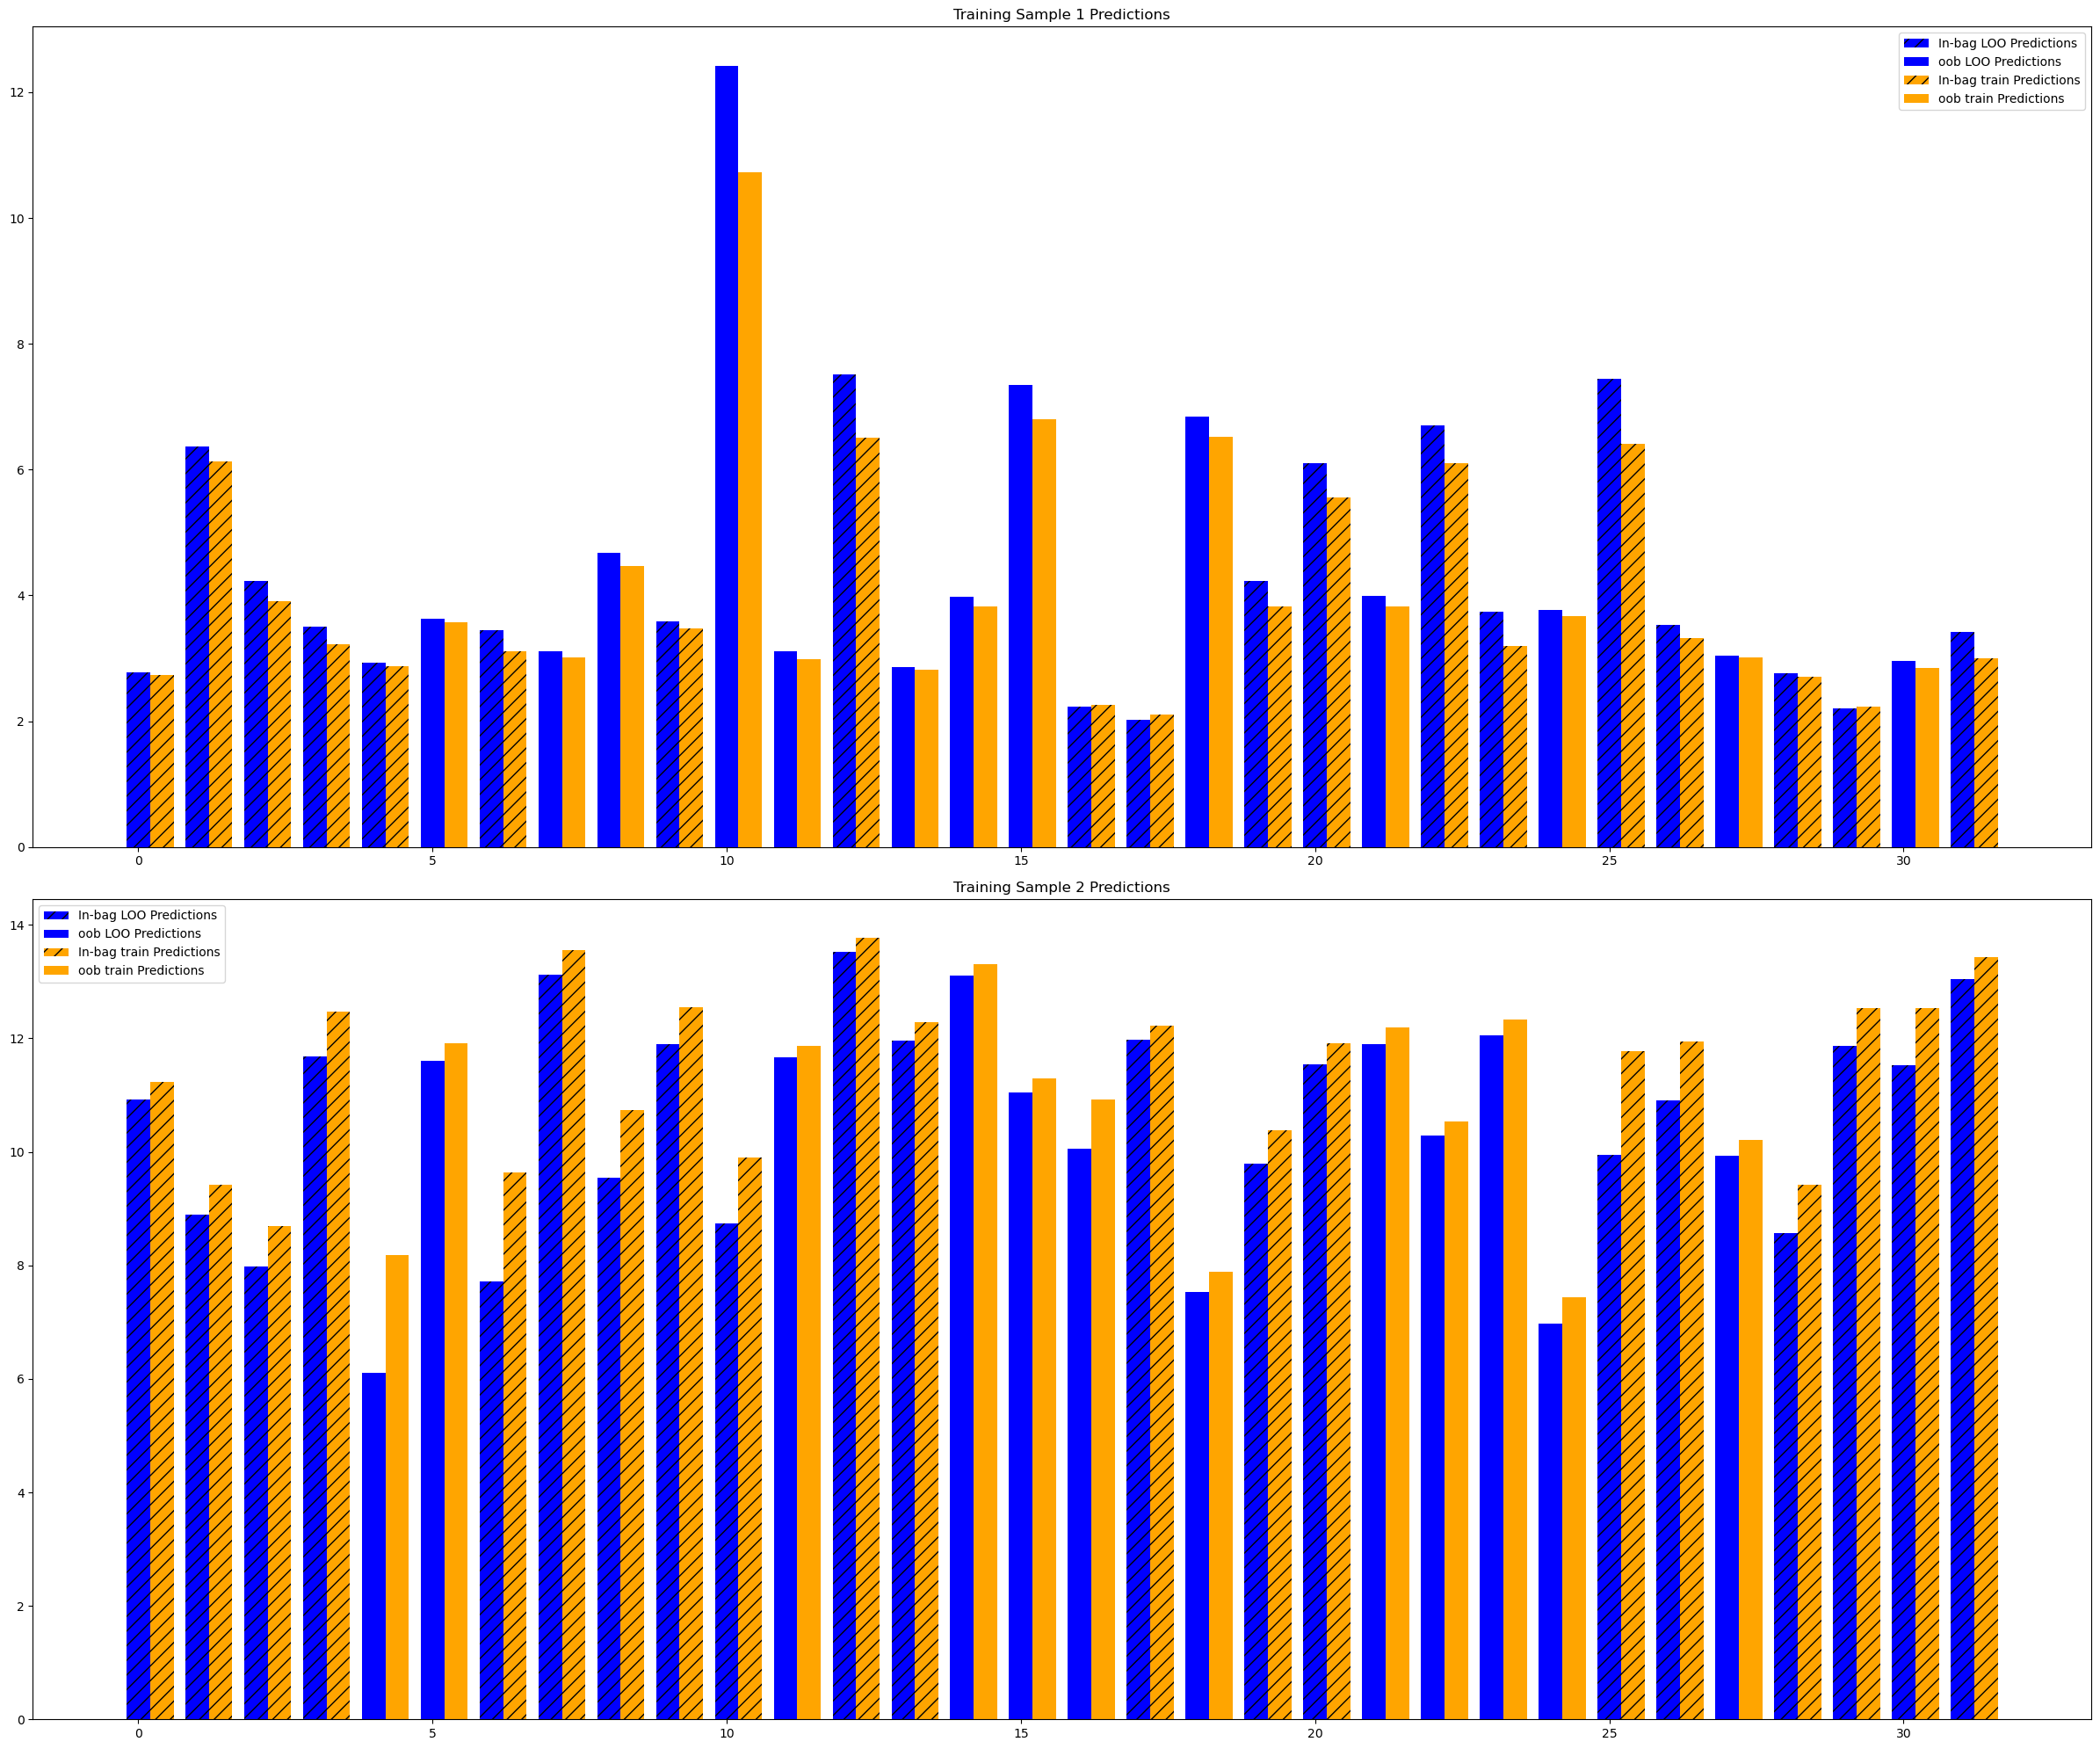

In [164]:
loo_pred_matrix = np.column_stack(loo_preds)
train_pred_matrix = np.column_stack(train_preds)

num_cols = loo_pred_matrix.shape[1]
fig, axes = plt.subplots(min(num_rows_to_show,2), 1, figsize=(24,20),sharey=False)

max_trees_to_show = 20
bar_width = 0.4

offset = 0
# Iterate over each row of the matrix
for i in range(min(num_rows_to_show,2)):
    # Get the current row data
    loo_row_data = loo_pred_matrix[i+offset]
    train_row_data = train_pred_matrix[i+offset]
    
    row_in_bag_indicator = sample_indicator_matrix[i]

    in_bag_trees = np.where(row_in_bag_indicator == 1)[0]
    out_of_bag_trees = np.where(row_in_bag_indicator == 0)[0]
    
    positions = range(max_trees_to_show)
    # Create a bar plot for the current row
    
    axes[i].bar(in_bag_trees, loo_row_data[in_bag_trees],width = bar_width,
                  color='blue', label='In-bag LOO Predictions',alpha = 1.0,hatch='//')

    axes[i].bar(out_of_bag_trees, loo_row_data[out_of_bag_trees],width = bar_width,
                  color='blue', label='oob LOO Predictions',alpha = 1.0)

    xticks_inbag = [x + bar_width for x in in_bag_trees]
    xticks_oob = [x + bar_width for x in out_of_bag_trees]
    
    axes[i].bar(xticks_inbag, train_row_data[in_bag_trees],width = bar_width,
                  color='orange', label='In-bag train Predictions',alpha = 1.0,hatch='//')

    axes[i].bar(xticks_oob, train_row_data[out_of_bag_trees],width = bar_width,
                  color='orange', label='oob train Predictions',alpha = 1.0)


    axes[i].set_title(f"Training sample {i+1} LOO vs train residuals across trees")
    axes[i].legend()
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    


    axes[i].set_title(f"Training Sample {i+1} Predictions")
    axes[i].legend()
    #axes[i][1].set_title(f"Training Sample Residuals")
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    

# Display the plot
plt.show()



## L0 Penalization for RF+ model

# Try Locally weighted sampling 

In [165]:
def compute_train_test_representations(rfplus_estimator,X_train,X_test):
    train_representations = []
    test_representations = []
    train_oob_representations = []
    for i in range(len(rfplus_estimator.transformers_)):
        ith_tree_train_transformed = rfplus_estimator.transformers_[i].transform(X_train).get_all_data()
        ith_tree_oob_train_transformed = rfplus_estimator.transformers_[i].transform(X_train[rf_plus_reg._oob_indices[i]]).get_all_data()
        ith_tree_test_transformed = rfplus_estimator.transformers_[i].transform(X_test).get_all_data()
        train_representations.append(ith_tree_train_transformed)
        train_oob_representations.append(ith_tree_oob_train_transformed)
        test_representations.append(ith_tree_test_transformed)
    return train_representations,train_oob_representations,test_representations

def compute_loo_oob_error_matrix(loo_error_matrix,rfplus_estimator):
    loo_oob_error_matrix = []
    for i in range(len(rfplus_estimator.transformers_)):
        ith_loo_oob_error = loo_error_matrix[rf_plus_reg._oob_indices[i],i]
        loo_oob_error_matrix.append(ith_loo_oob_error)
    return loo_oob_error_matrix

def compute_train_test_distance(train_rep_list,test_rep_list,similarities = 'euclidean'):
    distances = []
    for i in range(len(train_rep_list)):
        train_rep = train_rep_list[i]
        test_rep = test_rep_list[i]
        if similarities == 'euclidean':
            train_test_tree_distance = euclidean_distances(test_rep,train_rep)
        if similarities == 'cosine':
            train_test_tree_distance = cosine_similarity(test_rep,train_rep)
        if similarities == 'rbf':
            train_test_tree_distance = rbf_kernel(test_rep,train_rep)
        if similarities == 'laplacian':
            train_test_tree_distance = laplacian_kernel(test_rep,train_rep)
        distances.append(train_test_tree_distance)
    return distances

# def compute_weighted_LOO_loss(exp_weighted_distance,loo_error_matrix):
#     weighted_LOO_losses = 
#     for i in range(len(exp_weighted_distance)):
#         ith_weighted_LOO_loss = np.sum(exp_weighted_distance[i]*loo_error_matrix[i])/np.sum(exp_weighted_distance[i])
#         weighted_LOO_losses.append(ith_weighted_LOO_loss)
#     return weighted_LOO_losses

In [166]:
train_representations,train_oob_representations,test_representations = compute_train_test_representations(rf_plus_reg,X_train,X_test)
train_test_distances = compute_train_test_distance(train_representations,test_representations,'euclidean')
oob_train_test_distances = compute_train_test_distance(train_oob_representations,test_representations,'euclidean')
loo_oob_error_matrix = compute_loo_oob_error_matrix(loo_error_matrix,rf_plus_reg)

Text(0, 0.5, 'Prediction')

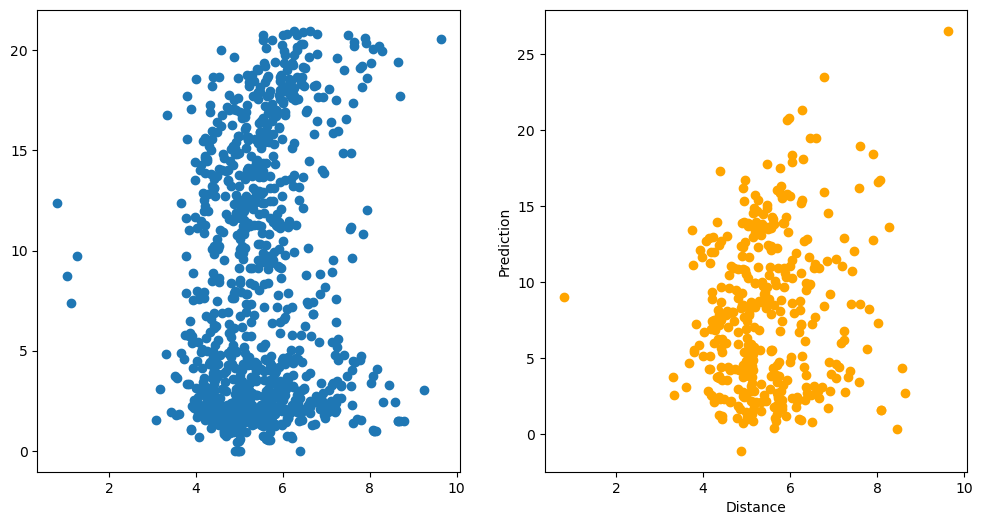

In [167]:
tree_idx = 6
test_idx = 2
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].scatter(train_test_distances[tree_idx][test_idx,:],y_train)#train_pred_matrix[:,tree_idx])
axs[1].scatter(oob_train_test_distances[tree_idx][test_idx,:],loo_pred_matrix[rf_plus_reg._oob_indices[tree_idx],tree_idx],color = 'orange')
plt.xlabel("Distance")
plt.ylabel("Prediction")

In [ ]:
# Training Distances vs Predictions